### Plot ice thickness maps for sensitivity experiments

#### Author: Jonathan Rheinlænder*
#### Date: Jun. 02 2022
#### Affiliation: Nansen Environmental and Remote Sensing Center, Bergen, Norway
*jonathan.rheinlaender@nersc.no


In [33]:
# allow plots to be interactive in the notebook
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import struct
import xarray as xr
from datetime import datetime
import matplotlib as mpl
import sys
import os
import cmocean 
import datetime as dt
from netCDF4 import Dataset
import matplotlib.gridspec as gridspec
from shutil import copyfile
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.colorbar import colorbar

import pynextsim.openers as pnops
import swarp_funs.mod_netcdf_utils as mnu
import pynextsim.gridding as png
from pynextsim.netcdf_list import NetcdfList
from pynextsim.irregular_grid_interpolator import IrregularGridInterpolator
from pynextsim.nextsim_bin import NextsimBin as nb
from pynextsim.projection_info import ProjectionInfo

import calc_leadfrac as clf


ModuleNotFoundError: No module named 'mpl_toolkits.axes_grid1.colorbar'

In [9]:
def mask_region(sio_mask, proj, mooring, n):
    """
    This function will compute mask
    :param sio_mask: masks from NSIDC (xarray)    
    :param proj: the projection used by NSIDC (projection_info object)
    :param mooring: moorings from nextsim (xarray)
    :param n: integer to pick which region to mask
    :return: boolean mask
    """
    # get variables from sio mask
    masks_nsidc = sio_mask["mask"][:]
    lon_nsidc = sio_mask.lon
    lat_nsidc = sio_mask.lat
    region_names = sio_mask['region_names']

    print("NSIDC grid extent:    ", lon_nsidc.values.min(), lon_nsidc.values.max(), 
          lat_nsidc.values.min(), lat_nsidc.values.max())

    # calculate x and y projection
    x_nsidc,y_nsidc= proj(lon_nsidc.values,lat_nsidc.values)
    
    #### I want an array with 0s everywhere but within the region I am interested
    mask_nsidc = np.zeros(masks_nsidc.shape)
    mask_nsidc[masks_nsidc==n] = 1
    print("Region: ", region_names[n-1].values)    # print region
    
    ### get lon, lat from nextsim
    nlon = mooring.longitude.values
    nlat = mooring.latitude.values
    
    # I project the model lon, lat on the nsidc projection and get 1d vector out of them
    x,y = proj(nlon, nlat)
    x = np.array(x) ; y=np.array(y)
    Nx     = x.size
    shp    = x.shape
    x_1d   = x.reshape(Nx)
    y_1d   = y.reshape(Nx)

    ##### This below cannot be removed, it is a trick: I use matplotlib to find the contour of my region
    all_paths = plt.contour(x_nsidc,y_nsidc,mask_nsidc,[0.5]).collections[0].get_paths()
    ##### I look for the biggest contour : WARNING, I might forget some little bits by doing that, I haven't checked too carefully
    max_len=0
    for i in range(len(all_paths)):
        if len(all_paths[i])>max_len:
            max_len=len(all_paths[i])
            bbPath=all_paths[i]
        
    ###### I select all the indexes that are within the (biggest) contour of my region
    coords = np.array([x_1d,y_1d]).transpose()
    mask_1d = np.array(bbPath.contains_points(coords),dtype=bool)

    ###### Back to 2d
    mask   = mask_1d.reshape(shp)
    print(mask, mask.shape)
    ##### A boolean array can also be useful
    mask_box = (mask==True)

    return mask

def make_figure(wi, hi, nrow,ncol):

    fig = plt.figure(figsize=(wi,hi))
    #plt.subplots_adjust(hspace=5, wspace=0.01, top=0.95, bottom=0.1, left=0.075, right=0.925)
    gs = gridspec.GridSpec(nrow,ncol)
    
    return fig, gs 


def plot(xa, gs, clim):
    ax = plt.subplot(gs,projection=ccrs.NorthPolarStereo(central_longitude=300), extent=[-110, 200, 67, 90])
    #make discrete colormap
    levels = np.arange(clim[0], clim[1], clim[2])
    bounds=np.linspace(0,4,9)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

    ax.coastlines(resolution='50m', linewidth=0.5)
    ax.gridlines(linewidth=0.5, alpha=0.5, linestyle='--')
    ax.set_extent(bbox, crs=ccrs.NorthPolarStereo())

    cs = ax.contourf(xa, origin='upper', extent=bbox, levels=levels,
                    extend='max', transform=ccrs.NorthPolarStereo())
    
    # add contour line
    cline = ax.contour(xa, origin='upper', extent=bbox, levels=[2], 
                       colors='k', linewidths=1, transform=ccrs.NorthPolarStereo())
    
    
#    fig.colorbar(cs, label='Thickness [m]', fraction=0.04, pad=0.02)
    ax.set_extent([-110, -50, 67, 90], ccrs.PlateCarree(central_longitude=300))
    
    return cs,ax


# Plot initial thickness distributions for sensitivity expts

Opening: /home/rheinlender/data/CS2_SMOS_v2.2/cs2_smos_ice_thickness_20130213-fv2p2.nc
reduce grid bbox:  [-2586312.2125342987, 2473129.954476453, -1921249.7233798755, 3126834.306605118]
Variable:  analysis_sea_ice_thickness
Reading external data (on same grid)
Variable:  analysis_sea_ice_thickness_unc
Reading external data (on same grid)
Variable:  sea_ice_concentration
Reading external data (on same grid)
Opening: /home/rheinlender/data/CS2_SMOS_v2.2/cs2_smos_ice_thickness_20130213-fv2p2_times0.5.nc
reduce grid bbox:  [-2586312.2125342987, 2473129.954476453, -1921249.7233798755, 3126834.306605118]
Variable:  analysis_sea_ice_thickness
Reading external data (on same grid)
Variable:  analysis_sea_ice_thickness_unc
Reading external data (on same grid)
Variable:  sea_ice_concentration
Reading external data (on same grid)
Opening: /home/rheinlender/data/CS2_SMOS_v2.2/cs2_smos_ice_thickness_20130213-fv2p2_times1.5.nc
reduce grid bbox:  [-2586312.2125342987, 2473129.954476453, -1921249.7233

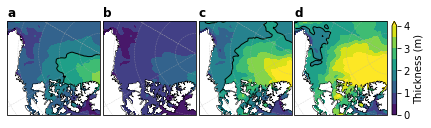

saving... /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/cs2smos_sit_beaufort_20130213_initial_fields.png


In [44]:
# environment variables
rootdir = '/home/rheinlender/shared-simstore-ns9829k/'
inpath = rootdir + 'home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/'
obsdir = '/home/rheinlender/data/'
outpath_plots =  rootdir + 'home/rheinlender/figs/breakup-paper/'

mooring_file = inpath + "expt_01_wrf10/outputs/Moorings.nc"

dto = dt.datetime(2013,2,13,12,0) # date to plot

fl = ['cs2_smos_ice_thickness_' + dto.strftime("%Y%m%d") + '-fv2p2.nc', 
      'cs2_smos_ice_thickness_' + dto.strftime("%Y%m%d") + '-fv2p2_times0.5.nc', 
     'cs2_smos_ice_thickness_' + dto.strftime("%Y%m%d") + '-fv2p2_times1.5.nc',
     'cs2_smos_ice_thickness_' + dto.strftime("%Y%m%d") + '-fv2p2_times2.0.nc',] 

# get cs2smos opener
o = pnops.OpenerCs2SmosThick()
o.variables['Thickness'].name = 'analysis_sea_ice_thickness'    

# read mooring file (for plotting)
moorings = NetcdfList([mooring_file])

# get bounding box from model (i.e. small_arctic_10km)
bbox = moorings.file_objects[0].get_bbox(o.projection.pyproj)
text = ('a', 'b', 'c', 'd')

# make figure
fig,gs = make_figure(6,2,1,4) 

i=0
for filename in fl:
    filename = obsdir + 'CS2_SMOS_v2.2/' + filename
    print("Opening:", filename)
    
    nci_obs = mnu.nc_getinfo(filename)
    obs_grid = png.Grid.init_from_nc_getinfo(nci_obs, projection=o.projection, bbox=bbox)    #cs2smos grid
    obs_vars = obs_grid.get_external_data(
                o.variables,
                dto,
                nci=nci_obs,
                data_on_same_grid=True, #we always use the obs grid
                allow_missing=True)

    sit = obs_vars['Thickness']

    # plotting
    cs,ax=plot(sit, gs[i], clim=[0.,4.5,0.5])
    
    ax.annotate(text[i], xy=(0., 1.05), xycoords="axes fraction", size=12, weight='bold')
        
    
    i+=1 

cax = inset_axes(fig.axes[3],
                    width="5%",  # width = 50% of parent_bbox width
                    height="100%",  # height : 5%
                    loc='lower left',
                    bbox_to_anchor=(1.05, 0., 1, 1),
                    bbox_transform=fig.axes[3].transAxes,
                    borderpad=0)

plt.colorbar(cs, cax=cax, label='Thickness (m)',  ticks=[0, 1, 2, 3, 4])
    
plt.subplots_adjust(wspace=0.03, hspace=0, top=0.95, bottom=0.1, left=0.02, right=0.9)
plt.show()   

title_string = ('wrf10', r'SIT$\times$0.5', r'SIT$\times$1.5', r'SIT$\times$2.0')
for i in range(0,len(fl)):
    ax=fig.axes[i]
    ax.set_title(title_string[i])

# save figure
figname = os.path.join(outpath_plots,
      '%s%s_%s_%s' % (outpath_plots, 'cs2smos_sit_beaufort', dto.strftime('%Y%m%d'), 'initial_fields.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')